In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
words = pd.read_csv('words', names=['word'])
words['word'] = words.word.str.lower()

# Make a table of 5 character words

In [3]:
words5 = words.where(words.word.str.len() == 5).dropna()

# Determine character distribution

In [4]:
# Split into table of characters
chars = words5.word.str.split('', expand=True).drop(labels=[0, 6], axis=1)
# Flatten table and count discrete values
charProbs = chars.stack().value_counts(normalize=True)

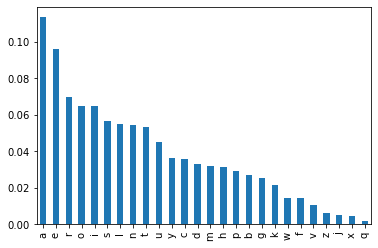

In [5]:
charProbs.plot.bar()

# Compute the boring score of each word

The boring score is a measure of how unique the characters in a word are. Words with a larger boring score have characters that appear very frequently. The boring score is computed by summing the frequency of each character in the 5 character word. Repeat characters are only counted once.

In [6]:
boringScore = pd.DataFrame(chars.apply(lambda row: sum([charProbs[c] for c in list(set(row))]), axis=1), columns=['score'])
boringScore = boringScore.join(words5)
boringScore.sort_values(by='score', ascending=False)

,score,word
13427,0.399961,arose
131939,0.399961,oreas
162889,0.399902,raise
13211,0.399902,arise
13178,0.399902,aries
...,...,...
38374,0.100762,cocco
210534,0.099629,ululu
74026,0.095699,fuffy
234250,0.095679,xylyl


In [89]:
def stepWordTable(tbl, include=[], exclude=[], inplace=[], guess=None):
    conds = ~tbl.word.isna()
    
    # Includes
    for c in include:
        conds &= tbl.word.str.contains(c)
    
    # Excludes
    if len(exclude) > 0:
        conds &= ~tbl.word.str.contains(f"[{''.join(exclude)}]")
    
    # In place
    for i,c in enumerate(inplace):
        if c is None:
            continue
        conds &= tbl.word.str[i] == c

    # Drop guess
    if guess is not None:
        conds &= ~tbl.word.str.match(guess)

    return tbl.where(conds).dropna(), (~conds).sum()

In [90]:
def checkWordleGuess(guess, word):
    correct = guess == word
    inWord = list(filter(None, [c if c in word else None for c in guess]))
    notInWord = list(set(guess) - set(inWord))
    inPlace = [c if c == w else None for c,w in zip(guess, word)]
    return (correct, inWord, notInWord, inPlace)

def solveWordle(boringScore, word):
    tbl = boringScore
    log = []
    included = []
    excluded = []
    inPlace = []
    lastIdx = 0
    
    while len(tbl) > 0:
        guess = tbl.nlargest(lastIdx + 1, 'score').iloc[-1].word
        log.append((len(tbl), guess))
        
        success, i, e, inPlace = checkWordleGuess(guess, word)
        if (success):
            return guess, log
        
        included = list(set(i + included))
        excluded = list(set(e + excluded))
        tbl, numDropped = stepWordTable(tbl, included, excluded, inPlace, guess)
        if numDropped == 0:
            lastIdx += 1
        else:
            lastIdx = 0
    
    return None, log

In [92]:
solveWordle(boringScore, 'proxy')

('proxy', [(10230, 'arose'), (81, 'irony'), (5, 'drovy'), (3, 'proxy')])